### Imports

In [1]:
import os
import keras
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

### Load and Preprocess the Dataset

In [2]:
# Set the path to your dataset
dataset_path = "...\fer2013"

# Function to load and preprocess the images with string labels
def load_images(folder_path):
    images = []
    labels = []
    label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        label_value = label_mapping[label]

        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = load_img(img_path, target_size=(96, 96))
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            images.append(img_array)
            labels.append(label_value)

    return np.array(images), np.array(labels)

### Loading Train Images

In [3]:
train_images, train_labels = load_images(os.path.join(dataset_path,'train'))

### Printing the number of samples in each class

In [4]:
# Count the number of samples in each class
label_counts = Counter(train_labels)

# Print the number of samples per class
inverse_label_mapping = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
for label, count in label_counts.items():
    print(f"{inverse_label_mapping[label]}: {count} samples")

angry: 3995 samples
disgust: 436 samples
fear: 4097 samples
happy: 7215 samples
neutral: 4965 samples
sad: 4830 samples
surprise: 3171 samples


### Loading Test Images

In [5]:
test_images, test_labels = load_images(os.path.join(dataset_path,'test'))

### Converting the labels to a one-hot encoding vector

In [6]:
train_labels = to_categorical(train_labels, num_classes = 7)
test_labels = to_categorical(test_labels, num_classes = 7)

### Model Definition and Compilation

In [7]:
Input_Layer = Input(shape=(96, 96, 3))

MobileNet_Model = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(96, 96, 3), input_tensor=Input_Layer)

MobileNet_Model.trainable = False

Flattened_output = Flatten()(MobileNet_Model.output)

mobile_model = Model(inputs = MobileNet_Model.input, outputs = Flattened_output)

mobile_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mobile_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Extracting the features from the pre-trained model

In [8]:
train_features = mobile_model.predict(train_images)
test_features = mobile_model.predict(test_images)

898/898 ━━━━━━━━━━━━━━━━━━━━ 104s 112ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step


### Using SMOTE (Synthetic Minority Over-sampling) technique for balancing the classes

In [9]:
smote = SMOTE()
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

### Ant Colony Optimization for Feature Selection

In [10]:
def ant_colony_optimization(n_ants, n_features, q0, rho, alpha, beta, max_iter, objective_function, *args):
    args = train_features_resampled, train_labels_resampled, test_features, test_labels
    pheromones = np.ones(n_features)
    best_features = None
    best_score = float('-inf')

    for iteration in range(max_iter):
        ant_solutions = generate_ant_solutions(pheromones, n_ants, n_features, q0, alpha, beta)
        scores = [objective_function(ant_solution, *args) for ant_solution in ant_solutions]

        if max(scores) > best_score:
            best_score = max(scores)
            best_features = ant_solutions[np.argmax(scores)]

        delta_pheromones = calculate_pheromone_delta(ant_solutions, scores, n_features)
        pheromones = update_pheromones(pheromones, delta_pheromones, rho)

    return best_features.astype(int)

def generate_ant_solutions(pheromones, n_ants, n_features, q0, alpha, beta):
    ant_solutions = []

    for ant in range(n_ants):
        features = construct_solution(pheromones, n_features, q0, alpha, beta)
        ant_solutions.append(features)

    return np.array(ant_solutions)

def construct_solution(pheromones, n_features, q0, alpha, beta):
    features = []
    remaining_features = np.array(list(range(n_features)))

    while remaining_features.size > 0:
        if np.random.rand() < q0:
            feature = select_best_feature(pheromones, remaining_features)
        else:
            feature = select_feature_probabilistic(pheromones, remaining_features, alpha, beta)
        remaining_features = np.setdiff1d(remaining_features, feature)
        features.append(feature)
    return np.array(features)

def select_best_feature(pheromones, remaining_features):
    heuristic_info = pheromones * (1.0 / np.arange(1, len(pheromones) + 1))
    valid_features = list(remaining_features)
    return valid_features[np.argmax(heuristic_info[valid_features])]

def select_feature_probabilistic(pheromones, remaining_features, alpha, beta):
    probabilities = pheromones[remaining_features] ** alpha
    probabilities *= (1.0 / np.arange(1, len(remaining_features) + 1)) ** beta
    probabilities /= probabilities.sum()
    selected_feature = np.random.choice(remaining_features, p=probabilities)
    return selected_feature

def calculate_pheromone_delta(ant_solutions, scores, n_features):
    delta_pheromones = np.zeros(n_features)
    for ant_solution, score in zip(ant_solutions, scores):
        delta_pheromones[ant_solution] += score
    return delta_pheromones

def update_pheromones(pheromones, delta_pheromones, rho):
    pheromones = pheromones * (1.0 - rho)
    pheromones += delta_pheromones
    return pheromones

def objective_function(features, *args):
    train_features_resampled, train_labels_resampled, test_features, test_labels = args
    features = features.astype(int)
    RF_Classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    RF_Classifier.fit(train_features_resampled[:, features], np.argmax(train_labels_resampled, axis=1))
    Accuracy = RF_Classifier.score(test_features[:, features], np.argmax(test_labels, axis=1))
    return Accuracy

### Adjusting the ACO Parameters

In [11]:
# ACO parameters
n_ants = 20
n_features = train_features_resampled.shape[1]
q0 = 0.9
rho = 0.2
alpha = 1.1
beta = 1.5
max_iter = 3

Optimized_Features = ant_colony_optimization(n_ants, n_features, q0, rho, alpha, beta, max_iter, objective_function, train_features_resampled, train_labels_resampled, test_features, test_labels )

### Random Forest Classification and Evaluation

In [12]:
RfClassifier = RandomForestClassifier(n_estimators=90, random_state=42)
RfClassifier.fit(train_features_resampled[:, Optimized_Features.astype(int)], np.argmax(train_labels_resampled, axis=1))

# Predict on the test data
Prediction = RfClassifier.predict(test_features[:, Optimized_Features.astype(int)])

# Calculate accuracy
Accuracy = accuracy_score(np.argmax(test_labels, axis=1), Prediction)

print("The Accuracy is:", Accuracy)

The Accuracy is: 0.49777096684313177


### Performance Metrics Calculation

Precision: 0.49803481282104944
Recall: 0.49777096684313177
F1-Score: 0.493020412901324


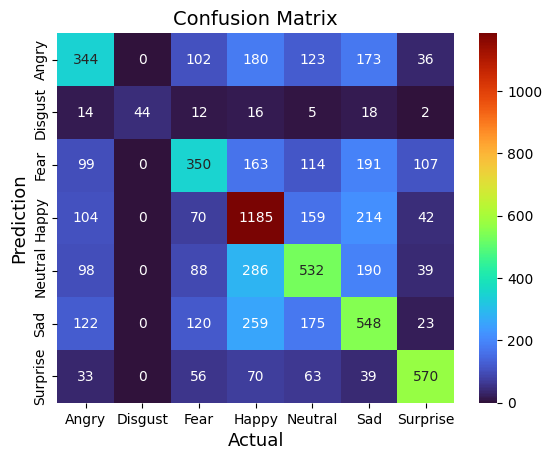

In [13]:
Precision = precision_score(np.argmax(test_labels, axis=1), Prediction, average='weighted')
Recall = recall_score(np.argmax(test_labels, axis=1), Prediction, average='weighted')
F1_Score = f1_score(np.argmax(test_labels, axis=1), Prediction, average='weighted')

print("Precision:", Precision)
print("Recall:", Recall)
print("F1-Score:", F1_Score)

class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

sns.heatmap(confusion_matrix(np.argmax(test_labels, axis=1), Prediction),
            annot=True,
            cmap='turbo',
            fmt='g',
            xticklabels=class_names,
            yticklabels=class_names)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix', fontsize=14)
plt.show()